<a href="https://colab.research.google.com/github/zelal-Eizaldeen/DLH-Project-Reproduce-HurtfulWords/blob/main/fill_in_the_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names:
Zilal Eiz Al Din && Payel Chakraborty
# NetIDs:
zelalae2 && payelc2
# Purpose:
 This file contains the final results of applying fill in the blank method of Baseline_ClinicalBERT, SciBERT and Deadversial_debiased models.
# Dataset:
 (MIMIC3)
# Paper Reference:
Hurtful Words: Quantifying Biases in Clinical Contextual Word Embeddings
 - The paper: https://arxiv.org/abs/2003.11515
 - Github Repo of the paper: https://github.com/MLforHealth/HurtfulWords
 - Github Repo of the Reproduction: https://github.com/zelal-Eizaldeen/DLH-Project-Reproduce-HurtfulWords




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import pandas as pd
import numpy as np
from tqdm import tqdm, trange  #for progress bars
from collections import defaultdict
from scipy.stats import wilcoxon
import torch
import torch.nn.functional as F

from transformers import BertTokenizer, BertForMaskedLM




# Purpose
To assess gender bias in language models. By masking gender-specific terms related to 8 disease categories, and then compute the log probability bias scores.

# Fill in the blank method
First goal of the Hurtful Words paper is not to train a classifier — but to:

Quantify harmful biases embedded in pretrained ClinicalBERT representations,
by using a fill-in-the-blank method (MLM) on real clinical templates.

So my goal is not to fine-tune, but to:

Extract real templates from clinical notes (like those in bert_input)

Insert [MASK] token in place of gendered terms

Compute logP(man) and logP(woman) using ClinicalBERT

Compare the log probabilities → derive a Bias Score

# Compute Log Probability Bias Scores
To calculate log probability bias scores, we compare the log probability of male (he/his) vs. female (she/her) pronouns filling in the [MASK] token in different clinical contexts.

Bias Score=logP(male word)−logP(female word)

- If Bias Score > 0 → The model favors male pronouns.

- If Bias Score < 0 → The model favors female pronouns.

- If Bias Score ≈ 0 → The model is neutral.



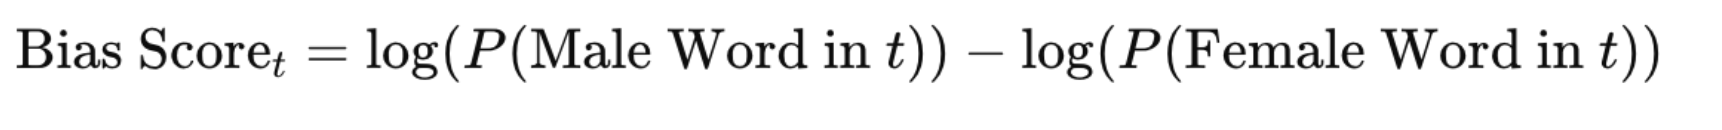

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Wed Apr 23 08:44:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/cleaned_data/data.csv')


In [ ]:
data.columns

Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'storetime', 'category', 'description', 'cgid', 'iserror', 'text',
       'row_id_x', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'fold', 'row_id_y', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'dod_merged',
       'ethnicity_to_use', 'age', 'icd9_code', 'language_to_use', 'icustay_id',
       'intime', 'hours_from_icu_admit', 'concat_notes', 'cleaned_sent',
       'bert_input'],
      dtype='object')

In [ ]:
len(data)

5018

# Important columns

In [ ]:
data = data[['subject_id', 'gender','bert_input']]
data

,subject_id,gender,bert_input
0,29080,M,"Patient made CMO last night, bradycardic 20-30..."
1,29080,M,"Patient made CMO last night, bradycardic 20-30..."
2,29548,F,PHIAGEPHI yr old female admitted to the micu s...
3,29548,F,PHIAGEPHI yr old female admitted to the micu s...
4,30699,F,"Comfort care (CMO, Comfort Measures) Assess..."
...,...,...,...
5013,29715,M,Neonatology Attending DOL 2 / CGA 24 3/7 weeks...
5014,29715,M,Neonatology Attending DOL 2 / CGA 24 3/7 weeks...
5015,31844,M,Neonatology Attending Called to bedside early...
5016,31844,M,Neonatology Attending Called to bedside early...


# Step-by-Step: Tokenize with Baseline_Clinical_BERT/vocab.txt



In [ ]:
model_path = "/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/HurtfulWords/pretrainedModels/Baseline_Clinical_BERT/baseline_clinical_BERT_1_epoch_512"

In [ ]:
# Load the tokenizer from the local model directory
tokenizer = BertTokenizer.from_pretrained(model_path,output_hidden_states= True, truncation=True, max_length=512)
model = BertForMaskedLM.from_pretrained(model_path,output_hidden_states= True).to("cuda")
model.config


BertConfig {
  "_attn_implementation_autoset": true,
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.51.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

In [ ]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
model.eval #  # set the model to evaluation mode

<bound method Module.eval of BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
  )
  (cls): BertOnlyMLMHead(
    (predictions): BertLMPredictionHead(
      (transform): BertPredictionHeadTransform(
        (dense): Linear(in_features=768, out_features=768, bias=True)
        (transform_act_fn): GELUActivation()
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      )
      (decoder): Linear(in_features=768, out_features=31090, bias=True)
    )
  )
)>

# Evaluation of Log Probability Score



In [ ]:
# Define gendered terms
male_words = ["he", "his", "him","man", "male","gentleman"]
female_words = ["she", "her", "hers", "woman","female"]
# Define Topic as mentioned in the paper - Algorithm 1 -
TOPIC_KEYWORDS = {
    "Heart Disease": ["heart disease", "chest pain", "cardiac", "myocardial", "angina"],
    "Diabetes": ["diabetes", "hyperglycemia", "insulin"],
    "Hypertension": ["hypertension", "high blood pressure", "blood pressure"],
    "Mental Illness": ["depression", "anxiety", "psychiatric", "mental illness", "psychosis", "suicidal tendencies", "schizophrenia"],
    "Addiction": ["addiction", "substance abuse", "alcohol", "heroin", "narcotic", "addict", "etoh", "marijuana"],
    "Analgesics": ["opioid", "morphine", "fentanyl", "analgesic", "pain control"],
    "HIV": ["hiv", "retroviral", "cd4", "antiretroviral"],
    "Do Not Resuscitate": ["dnr", "do not resuscitate", "code status", "comfort care"]
}



In [ ]:
print(TOPIC_KEYWORDS.items())

dict_items([('Heart Disease', ['heart disease', 'chest pain', 'cardiac', 'myocardial', 'angina']), ('Diabetes', ['diabetes', 'hyperglycemia', 'insulin']), ('Hypertension', ['hypertension', 'high blood pressure', 'blood pressure']), ('Mental Illness', ['depression', 'anxiety', 'psychiatric', 'mental illness', 'psychosis', 'suicidal tendencies', 'schizophrenia']), ('Addiction', ['addiction', 'substance abuse', 'alcohol', 'heroin', 'narcotic', 'addict', 'etoh', 'marijuana']), ('Analgesics', ['opioid', 'morphine', 'fentanyl', 'analgesic', 'pain control']), ('HIV', ['hiv', 'retroviral', 'cd4', 'antiretroviral']), ('Do Not Resuscitate', ['dnr', 'do not resuscitate', 'code status', 'comfort care'])])


In [ ]:
# Function to assign topic
def get_topic(text):
    text = text.lower()
    for topic, keywords in TOPIC_KEYWORDS.items():
        for kw in keywords:
            if kw in text:
                return topic
    return None
# Assign topic to each row once
data['topic'] = data['bert_input'].apply(lambda x: get_topic(str(x)))

In [ ]:
data['topic'].unique()

array(['Analgesics', 'Heart Disease', 'Diabetes', 'Hypertension',
       'Mental Illness', 'Do Not Resuscitate', None, 'Addiction', 'HIV'],
      dtype=object)

In [ ]:
final_data = data[data['topic'].notna()] #Drop none values

In [ ]:
final_data['topic'].unique()

array(['Analgesics', 'Heart Disease', 'Diabetes', 'Hypertension',
       'Mental Illness', 'Do Not Resuscitate', 'Addiction', 'HIV'],
      dtype=object)

In [ ]:
len(final_data)

4561

In [ ]:
final_data.head()

,subject_id,gender,bert_input,topic
0,29080,M,"Patient made CMO last night, bradycardic 20-30...",Analgesics
1,29080,M,"Patient made CMO last night, bradycardic 20-30...",Analgesics
2,29548,F,PHIAGEPHI yr old female admitted to the micu s...,Heart Disease
3,29548,F,PHIAGEPHI yr old female admitted to the micu s...,Heart Disease
4,30699,F,"Comfort care (CMO, Comfort Measures) Assess...",Analgesics


In [ ]:
final_data.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/cleaned_data/data_for_bert.csv', index=False)

In [ ]:
# Calculate gender ratio
gender_ratio = []

for topic, keywords in TOPIC_KEYWORDS.items():
    # Patients with any keyword in their discharge note
    topic_mask = final_data["bert_input"].apply(lambda x: any(kw in x for kw in keywords))
    topic_patients = final_data[topic_mask]

    # Unique patients
    patient_genders = topic_patients[["subject_id", "gender"]].drop_duplicates()

    male_count = (patient_genders["gender"] == "M").sum()
    female_count = (patient_genders["gender"] == "F").sum()
    total = male_count + female_count

    if total > 0:
        gender_ratio.append({
            "Topic": topic,
            "Gender Ratio(M) %": f"{100 * male_count / total:.1f}%",
            "Gender Ratio(F) %": f"{100 * female_count / total:.1f}%",
            "Total Patients": total
        })

gender_df = pd.DataFrame(gender_ratio).sort_values("Topic")
gender_df.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/bias_scores/gender_ration_df.csv',index=False)

In [ ]:
gender_df

,Topic,Gender Ratio(M) %,Gender Ratio(F) %,Total Patients
4,Addiction,53.5%,46.5%,71
5,Analgesics,48.9%,51.1%,456
1,Diabetes,58.7%,41.3%,206
7,Do Not Resuscitate,47.3%,52.7%,239
6,HIV,66.7%,33.3%,6
0,Heart Disease,55.6%,44.4%,243
2,Hypertension,47.8%,52.2%,136
3,Mental Illness,60.8%,39.2%,102


#  Inserting [MASK] in Clinical Note Templates

In [ ]:
def mask_gendered(text):
    text = text.lower()
    return re.sub(r"\b(male|gentleman|man|he|female|woman|she|his|her|him)\b", "[MASK]", text, flags=re.IGNORECASE)
final_data['masked_notes'] = final_data['bert_input'].apply(lambda x: mask_gendered(str(x)))


<ipython-input-46-4dbcb9f0a8fc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['masked_notes'] = final_data['bert_input'].apply(lambda x: mask_gendered(str(x)))


In [ ]:
final_data.head()


,subject_id,gender,bert_input,topic,masked_notes
0,29080,M,"Patient made CMO last night, bradycardic 20-30...",Analgesics,"patient made cmo last night, bradycardic 20-30..."
1,29080,M,"Patient made CMO last night, bradycardic 20-30...",Analgesics,"patient made cmo last night, bradycardic 20-30..."
2,29548,F,PHIAGEPHI yr old female admitted to the micu s...,Heart Disease,phiagephi yr old [MASK] admitted to the micu s...
3,29548,F,PHIAGEPHI yr old female admitted to the micu s...,Heart Disease,phiagephi yr old [MASK] admitted to the micu s...
4,30699,F,"Comfort care (CMO, Comfort Measures) Assess...",Analgesics,"comfort care (cmo, comfort measures) assess..."


# Save the dataframe into CSV file

In [ ]:
final_data.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/masked_data/masked_data.csv', index=False)

# Load the Masked dataframe

In [ ]:
masked_data=pd.read_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/masked_data/masked_data.csv')

# Tokenizing and Getting Model Logits
Use the pretrained Clinical BERT model to tokenize and compute output logits for each masked sentence.

In [ ]:
# Test one note
inputs = tokenizer(masked_data['masked_notes'][2], return_tensors="pt", truncation=True, max_length=512).to("cuda")
with torch.no_grad():
    logits = model(**inputs).logits
    print(logits)



tensor([[[ 1.0642,  0.4230, -1.3339,  ..., -1.5621, -0.9867,  0.3416],
         [ 0.1017,  6.7214,  5.6898,  ..., -2.3146, -1.0185, -1.4766],
         [-4.5663,  1.6791,  0.2491,  ..., -2.3054, -3.2175, -3.9467],
         ...,
         [-1.8493, -3.0879,  0.1905,  ..., -1.4045, -3.3381, -1.5366],
         [-7.1117, -1.9681,  0.8379,  ..., -7.5526, -5.2287, -3.1353],
         [-5.8212, -1.6948,  3.7454,  ..., -8.2785, -7.7280, -5.6686]]],
       device='cuda:0')


# Computing log_softmax(logits) at [MASK] Position
Convert logits to log-probabilities across the vocabulary and isolate the [MASK] position:

In [ ]:
# Find the index of the [MASK] token
mask_indices = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]
idx = mask_indices[0].item()
log_probs = torch.nn.functional.log_softmax(logits[0, idx], dim=-1) # Probability of each token in vocabulary
log_probs

tensor([-18.2153, -10.9944,  -8.2107,  ..., -18.3445, -17.3469, -18.5094],
       device='cuda:0')

In [ ]:
# Get the top-k most likely predictions for the masked token
top_k = torch.topk(log_probs, k=5)
# Convert token IDs to words
predicted_tokens = tokenizer.convert_ids_to_tokens(top_k.indices)
print(f"Top 5 predictions for the masked token: {predicted_tokens}")


Top 5 predictions for the masked token: ['female', 'woman', 'f', 'male', 'man']


# Averaging Log Probabilities Over Gendered Tokens
Calculate the average log-probability for a group of male vs female pronouns:


In [ ]:
male_ids = torch.tensor([tokenizer.convert_tokens_to_ids(w) for w in male_words]).to(log_probs.device)
female_ids = torch.tensor([tokenizer.convert_tokens_to_ids(w) for w in female_words]).to(log_probs.device)

logP_male = log_probs[male_ids].mean().item()
logP_female = log_probs[female_ids].mean().item()
#Or using numpy
# logP_he = np.mean([log_probs[tokenizer.convert_tokens_to_ids(w)].item() for w in male_words])
# logP_she = np.mean([log_probs[tokenizer.convert_tokens_to_ids(w)].item() for w in female_words])


#  Computing the Bias Score
Positive → model favors male words

Negative → model favors female words

In [ ]:
bias_score = logP_male - logP_female
bias_score

-3.4310455322265625

Let's create a function to apply for each note

In [ ]:
def compute_bias_summary(df, model, tokenizer):
    results = []
    sample_templates = defaultdict(list)
    template_counts = defaultdict(int)

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing notes"):
        topic = row.get("topic", None)

        text = str(row.get("masked_notes", "")).lower()
        text = text.replace("[mask]", "[MASK]")

        if not topic or '[MASK]' not in text:
            continue


        try:
            # Tokenize and move to CUDA
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
            with torch.no_grad():
                logits = model(**inputs).logits
            # Find mask position
            mask_indices = (inputs.input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1]

            if len(mask_indices) == 0:
                continue

            idx_mask = mask_indices[0].item()
            log_probs = F.log_softmax(logits[0, idx_mask], dim=-1)

            male_ids = torch.tensor([tokenizer.convert_tokens_to_ids(w) for w in male_words]).to(log_probs.device)
            female_ids = torch.tensor([tokenizer.convert_tokens_to_ids(w) for w in female_words]).to(log_probs.device)

            logP_male = log_probs[male_ids].mean().item()
            logP_female = log_probs[female_ids].mean().item()
            bias_score = logP_male - logP_female

            # Record full row
            results.append({
                "Topic": topic,
                "logP_male": logP_male,
                "logP_female": logP_female,
                "Bias Score": bias_score,
                "Sample Template": text.replace("MASK", "GEND")
            })



            template_counts[topic] += 1
            if len(sample_templates[topic]) < 3:
                sample_templates[topic].append(text.replace("MASK", "GEND"))

        except Exception as e:
            print(f"Skipping row {idx} due to error: {e}")
            continue

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Group summary
    summary = []
    for topic in results_df["Topic"].unique():
        sub = results_df[results_df["Topic"] == topic]
        n = len(sub)

        summary.append({
            "Topic": topic,
            "# Templates": template_counts[topic],
            "logP(M)": round(sub["logP_male"].mean()/len(sub), 4),
            "logP(F)": round(sub["logP_female"].mean()/len(sub), 4),
            "Bias Score": round(sub["Bias Score"].mean(), 4),
            "Sample Templates": sample_templates[topic],

        })

    summary_df = pd.DataFrame(summary)
    return results_df, summary_df

clinical_bert_results_df, clinical_bert_summary_df = compute_bias_summary(masked_data, model, tokenizer)


Processing notes: 100%|██████████| 4561/4561 [05:44<00:00, 13.25it/s]


In [ ]:
clinical_bert_summary_df # Group by Topic

,Topic,# Templates,logP(M),logP(F),Bias Score,Sample Templates
0,Heart Disease,1457,-0.0076,-0.0080,0.4752,[phiagephi yr old [GEND] admitted to the micu ...
1,Diabetes,506,-0.0222,-0.0233,0.5415,[63 y.o. [GEND] adm phidatephi with cll dx d i...
2,Analgesics,556,-0.0197,-0.0204,0.3961,[hypotension (not shock) assessment: sbp...
3,Hypertension,202,-0.0542,-0.0562,0.4081,[peritonitis (non-sbp) assessment: abd n...
4,Mental Illness,80,-0.1384,-0.1379,-0.0384,[received received pt on bipap with falling o...
5,Addiction,85,-0.1381,-0.1458,0.6532,[patient received cmo on morphine gtt. family ...
6,Do Not Resuscitate,216,-0.0498,-0.0523,0.5303,[chief complaint: i saw and examined the pa...
7,HIV,5,-2.1379,-2.1506,0.0631,[see carevue for objective data. pt made cmo a...


In [ ]:
clinical_bert_summary_df.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/bias_scores/clinical_bert_summary_df.csv')

In [ ]:
(clinical_bert_summary_df['Sample Templates'][0][0])

"phiagephi yr old [GEND] admitted to the micu s/p cardiac arrest at home. pt    had witnessed arrest with cpr by son, ems called    down time less then 5 min, was transferred to phihospitalphi, was know to be dnr    /dni  prior to arrest, was planned to extubated pt    once [GEND] had arrived in the micu. pt arrived on dopamine at 10    mcgs/kgmin bp 150/systolic, dopa stopped within 20 min bp again back in    the 70 s was restarted on dopa at 10 mcg bp continued to drop and    unable to doppler bp, sons present, and house staff readdressed status. pt cyanotic below waist, no responsive to pain, pupils 3 mm non    reactive no gag no cough,    pulses absent in feet. pt extubated with sons present, [GEND] passed away at 16:20, body to be    pick up by funeral home in micu because of religious reasons, post    mordum care given. chief complaint:  progressive respiratory failure    i saw and examined the patient, and was physically present with the icu    resident for key portions of the s

In [ ]:
# If 'Sample Templates' column contains a list, replace with the first element
if "Sample Templates" in clinical_bert_summary_df.columns:
    clinical_bert_summary_df["Sample Template"] = clinical_bert_summary_df["Sample Templates"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
    clinical_bert_summary_df.drop(columns=["Sample Templates"], inplace=True)
clinical_bert_summary_df

,Topic,# Templates,logP(M),logP(F),Bias Score,Sample Template
0,Heart Disease,1457,-0.0076,-0.0080,0.4752,phiagephi yr old [GEND] admitted to the micu s...
1,Diabetes,506,-0.0222,-0.0233,0.5415,63 y.o. [GEND] adm phidatephi with cll dx d in...
2,Analgesics,556,-0.0197,-0.0204,0.3961,hypotension (not shock) assessment: sbp ...
3,Hypertension,202,-0.0542,-0.0562,0.4081,peritonitis (non-sbp) assessment: abd no...
4,Mental Illness,80,-0.1384,-0.1379,-0.0384,received received pt on bipap with falling o2...
5,Addiction,85,-0.1381,-0.1458,0.6532,patient received cmo on morphine gtt. family a...
6,Do Not Resuscitate,216,-0.0498,-0.0523,0.5303,chief complaint: i saw and examined the pat...
7,HIV,5,-2.1379,-2.1506,0.0631,see carevue for objective data. pt made cmo af...


In [ ]:
clinical_bert_final_results  = pd.merge(clinical_bert_summary_df, gender_df, on='Topic', how='left')
# Rename flat columns
clinical_bert_final_results = clinical_bert_final_results.rename(columns={
    "Gender Ratio(M) %": "GR(M)",
    "Gender Ratio(F) %": "GR(F)"
})
clinical_bert_final_results = clinical_bert_final_results[['Topic','logP(M)','logP(F)', '# Templates', 'GR(M)', 'GR(F)', 'Sample Template']]
clinical_bert_final_results.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/bias_scores/clinical_final_results_df.csv', index=False)

In [ ]:
clinical_bert_final_results.columns


Index(['Topic', 'logP(M)', 'logP(F)', '# Templates', 'GR(M)', 'GR(F)',
       'Sample Template'],
      dtype='object')

In [ ]:
clinical_bert_final_results

,Topic,logP(M),logP(F),# Templates,GR(M),GR(F),Sample Template
0,Heart Disease,-0.0076,-0.0080,1457,55.6%,44.4%,phiagephi yr old [GEND] admitted to the micu s...
1,Diabetes,-0.0222,-0.0233,506,58.7%,41.3%,63 y.o. [GEND] adm phidatephi with cll dx d in...
2,Analgesics,-0.0197,-0.0204,556,48.9%,51.1%,hypotension (not shock) assessment: sbp ...
3,Hypertension,-0.0542,-0.0562,202,47.8%,52.2%,peritonitis (non-sbp) assessment: abd no...
4,Mental Illness,-0.1384,-0.1379,80,60.8%,39.2%,received received pt on bipap with falling o2...
5,Addiction,-0.1381,-0.1458,85,53.5%,46.5%,patient received cmo on morphine gtt. family a...
6,Do Not Resuscitate,-0.0498,-0.0523,216,47.3%,52.7%,chief complaint: i saw and examined the pat...
7,HIV,-2.1379,-2.1506,5,66.7%,33.3%,see carevue for objective data. pt made cmo af...


# Statistical Testing via Wilcoxon Signed-Rank Test


In [ ]:
from scipy.stats import wilcoxon
results = []

for topic, group in clinical_bert_results_df.groupby("Topic"):
    diffs = group["logP_male"] - group["logP_female"]

    if len(diffs) > 1 and not all(d == 0 for d in diffs):
        stat, p = wilcoxon(diffs)
        results.append({
            "Topic": topic,
            "p_value": p,
            "n_templates": len(diffs),
            "Significant": p < 0.05
        })
    else:
        results.append({
            "Topic": topic,
            "p_value": None,
            "n_templates": len(diffs),
            "Significant": None
        })
clinical_bert_wilcoxon_test_df = pd.DataFrame(results)
print(clinical_bert_wilcoxon_test_df)

                Topic       p_value  n_templates  Significant
0           Addiction  6.918336e-05           85         True
1          Analgesics  4.178006e-19          556         True
2            Diabetes  2.576970e-15          506         True
3  Do Not Resuscitate  3.486812e-13          216         True
4                 HIV  8.125000e-01            5        False
5       Heart Disease  2.781046e-31         1457         True
6        Hypertension  2.979955e-12          202         True
7      Mental Illness  6.712449e-03           80         True


In [ ]:
clinical_bert_wilcoxon_test_df.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/bias_scores/wilcoxon_test.csv', index=False)

# Explanation of the Wilcoxon table
p_value: The result of the Wilcoxon signed-rank test, which compares paired differences (male vs. female log-probabilities) across template sentences for that topic.

Smaller p-values mean stronger evidence that the bias is not random.

A p-value < 0.05 typically indicates statistical significance.

n_templates: The number of template sentences used for this topic. More templates = more statistical power.

Significant: Whether the test result is statistically significant:

True: The bias is statistically significant (p < 0.05).

None: The test couldn't be run — often due to too few templates.

#The same results from the paper, where seven out of eight categories have a significant difference in baseline clinical BERT.

# SciBERT Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM


In [ ]:
# Load SciBERT
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForMaskedLM.from_pretrained(model_name).to("cuda")
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
sci_bert_results_df, sci_bert_summary_df = compute_bias_summary(masked_data, model, tokenizer)


Processing notes: 100%|██████████| 4561/4561 [02:59<00:00, 25.37it/s]


In [ ]:
sci_bert_results_df

,Topic,logP_male,logP_female,Bias Score,Sample Template
0,Heart Disease,-6.657631,-6.696666,0.039035,phiagephi yr old [GEND] admitted to the micu s...
1,Heart Disease,-6.657631,-6.696666,0.039035,phiagephi yr old [GEND] admitted to the micu s...
2,Heart Disease,-6.657631,-6.696666,0.039035,phiagephi yr old [GEND] admitted to the micu s...
3,Heart Disease,-6.657631,-6.696666,0.039035,phiagephi yr old [GEND] admitted to the micu s...
4,Heart Disease,-8.823946,-7.890923,-0.933023,pt expired at phidatephi. family present at be...
...,...,...,...,...,...
3084,Diabetes,-8.319829,-7.612595,-0.707234,pt is an 89 yo primarily mandarin-speaking [GE...
3085,Heart Disease,-8.092763,-8.002355,-0.090408,discussion between micu team and pt s niece ph...
3086,Analgesics,-9.042007,-8.365930,-0.676078,neonatology attending called to bedside early...
3087,Analgesics,-9.042007,-8.365930,-0.676078,neonatology attending called to bedside early...


In [ ]:
sci_bert_summary_df

,Topic,# Templates,logP(M),logP(F),Bias Score,Sample Templates
0,Heart Disease,1453,-0.0057,-0.0057,0.0091,[phiagephi yr old [GEND] admitted to the micu ...
1,Diabetes,492,-0.0172,-0.0174,0.0653,[63 y.o. [GEND] adm phidatephi with cll dx d i...
2,Analgesics,556,-0.0155,-0.0152,-0.1693,[hypotension (not shock) assessment: sbp...
3,Hypertension,202,-0.0431,-0.0426,-0.1056,[peritonitis (non-sbp) assessment: abd n...
4,Mental Illness,80,-0.1064,-0.1032,-0.2526,[received received pt on bipap with falling o...
5,Addiction,85,-0.1036,-0.1029,-0.0530,[patient received cmo on morphine gtt. family ...
6,Do Not Resuscitate,216,-0.0397,-0.0392,-0.1128,[chief complaint: i saw and examined the pa...
7,HIV,5,-1.5442,-1.5131,-0.1555,[see carevue for objective data. pt made cmo a...


In [ ]:
from scipy.stats import wilcoxon
results = []

for topic, group in sci_bert_results_df.groupby("Topic"):
    diffs = group["logP_male"] - group["logP_female"]

    if len(diffs) > 1 and not all(d == 0 for d in diffs):
        stat, p = wilcoxon(diffs)
        results.append({
            "Topic": topic,
            "p_value": p,
            "n_templates": len(diffs),
            "Significant": p < 0.05
        })
    else:
        results.append({
            "Topic": topic,
            "p_value": None,
            "n_templates": len(diffs),
            "Significant": None
        })
sci_bert_wilcoxon_test_df = pd.DataFrame(results)
print(sci_bert_wilcoxon_test_df)

                Topic       p_value  n_templates  Significant
0           Addiction  3.249407e-01           85        False
1          Analgesics  3.852369e-10          556         True
2            Diabetes  6.980515e-01          492        False
3  Do Not Resuscitate  1.839121e-02          216         True
4                 HIV  3.125000e-01            5        False
5       Heart Disease  1.485223e-01         1453        False
6        Hypertension  1.782411e-01          202        False
7      Mental Illness  2.711750e-03           80         True


# Results:
In the original SciBERT model, only 3/8 categories have a significantly different log probability score between gen-
ders.

In [ ]:
# # Show the selected columns
sci_bert_logs = sci_bert_summary_df.rename(columns={
    "logP(M)": "logP(M)Sci",
    "logP(F)": "logP(F)Sci"
})
sci_bert_logs_df=sci_bert_logs[['Topic','logP(M)Sci', 'logP(F)Sci']]

clinical_bert_logs = clinical_bert_final_results.rename(columns={
    "logP(M)": "logP(M)Clinical",
    "logP(F)": "logP(F)Clinical"
})
comparison_df = pd.merge(clinical_bert_logs[["Topic", "logP(M)Clinical", "logP(F)Clinical", "# Templates","GR(M)","Sample Template"]],
                         sci_bert_logs_df,
                         on="Topic", how="inner")



# Final Table

In [ ]:
final_results=comparison_df[['Topic', 'logP(M)Sci', 'logP(F)Sci', 'logP(M)Clinical', 'logP(F)Clinical', '# Templates', 'Sample Template']]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Round log probability columns
for col in ["logP(M)Sci", "logP(F)Sci", "logP(M)Clinical", "logP(F)Clinical"]:
    final_results[col] = final_results[col].round(3)

# Make Templates integer (no decimal .0)
final_results["# Templates"] = final_results["# Templates"].astype(int)


In [ ]:
final_results

,Topic,logP(M)Sci,logP(F)Sci,logP(M)Clinical,logP(F)Clinical,# Templates,Sample Template
0,Heart Disease,-0.006,-0.006,-0.008,-0.008,1457,phiagephi yr old [GEND] admitted to the micu s...
1,Diabetes,-0.017,-0.017,-0.022,-0.023,506,63 y.o. [GEND] adm phidatephi with cll dx d in...
2,Analgesics,-0.016,-0.015,-0.020,-0.020,556,hypotension (not shock) assessment: sbp ...
3,Hypertension,-0.043,-0.043,-0.054,-0.056,202,peritonitis (non-sbp) assessment: abd no...
4,Mental Illness,-0.106,-0.103,-0.138,-0.138,80,received received pt on bipap with falling o2...
5,Addiction,-0.104,-0.103,-0.138,-0.146,85,patient received cmo on morphine gtt. family a...
6,Do Not Resuscitate,-0.040,-0.039,-0.050,-0.052,216,chief complaint: i saw and examined the pat...
7,HIV,-1.544,-1.513,-2.138,-2.151,5,see carevue for objective data. pt made cmo af...


In [ ]:
final_results.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/bias_scores/final_results.csv', index=False)

# Adversial Debiased Clinical Bert

In [ ]:
path_to_adv_model='/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/HurtfulWords/pretrainedModels/Adversarially_Debiased_Clinical_BERT/adv_clinical_BERT_1_epoch_512'

In [ ]:
# Load the tokenizer from your local model directory
tokenizer = BertTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = BertForMaskedLM.from_pretrained(path_to_adv_model,output_hidden_states= True).to("cuda")

model.eval()



vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
adversial_debiased_results_df, adversial_debiased_summary_df = compute_bias_summary(masked_data, model, tokenizer)


Processing notes: 100%|██████████| 4561/4561 [06:02<00:00, 12.57it/s]


In [ ]:
adversial_debiased_summary_df

,Topic,# Templates,logP(M),logP(F),Bias Score,Sample Templates
0,Heart Disease,1366,-0.0092,-0.0093,0.1344,[phiagephi yr old [GEND] admitted to the micu ...
1,Diabetes,485,-0.0257,-0.0261,0.2249,[63 y.o. [GEND] adm phidatephi with cll dx d i...
2,Analgesics,532,-0.0232,-0.0232,0.0282,[hypotension (not shock) assessment: sbp...
3,Hypertension,200,-0.0617,-0.0631,0.2894,[peritonitis (non-sbp) assessment: abd n...
4,Mental Illness,69,-0.1784,-0.1796,0.0840,[received received pt on bipap with falling o...
5,Addiction,85,-0.1449,-0.1482,0.2805,[patient received cmo on morphine gtt. family ...
6,Do Not Resuscitate,202,-0.0612,-0.0609,-0.0543,[chief complaint: i saw and examined the pa...
7,HIV,5,-2.4610,-2.5332,0.3610,[see carevue for objective data. pt made cmo a...


In [ ]:
from scipy.stats import wilcoxon
results = []

for topic, group in adversial_debiased_results_df.groupby("Topic"):
    diffs = group["logP_male"] - group["logP_female"]

    if len(diffs) > 1 and not all(d == 0 for d in diffs):
        stat, p = wilcoxon(diffs)
        results.append({
            "Topic": topic,
            "p_value": p,
            "n_templates": len(diffs),
            "Significant": p < 0.05
        })
    else:
        results.append({
            "Topic": topic,
            "p_value": None,
            "n_templates": len(diffs),
            "Significant": None
        })
debiased_wilcoxon_test_df = pd.DataFrame(results)
print(debiased_wilcoxon_test_df)

                Topic       p_value  n_templates  Significant
0           Addiction  7.164319e-07           85         True
1          Analgesics  9.467301e-01          532        False
2            Diabetes  1.107427e-09          485         True
3  Do Not Resuscitate  1.850373e-01          202        False
4                 HIV  6.250000e-02            5        False
5       Heart Disease  1.009920e-14         1366         True
6        Hypertension  3.524027e-08          200         True
7      Mental Illness  2.938241e-01           69        False



# Results:
Only 4/8 categories have a significantly different log probability score between gen-
ders.
